# Earthquake detection

The first step in the process of developing an earthquake catalogue is to detect earthquakes.  The efficacy of the detection system has a fundamental impact on the completeness of a given catalogue: if you can't detect an earthquake, you can't do anything else with it either.

## Brief history:
1. Visual identification of earthquakes on drums;
2. Triggered digital seismographs - usually triggered by an energy detector;
3. Continuous data (due to the availability of large digital storage media) and offline detection using techniques including:
    - Energy detectors like STA/LTA
    - Similarity detectors
    - Machine learning

## What makes an earthquake different from noise?

To start off, lets think about how we would notice an earthquake in a seismogram. The key things to look out for are:
1. Amplitude change (but small earthquakes may fall below the noise level);
2. Frequency change (but then we miss low-frequency earthquakes...);
3. Polarization changes - P and S waves are polarized, noise is generally randomly polarized.

Lets look at some of these changes in a seismic sequence.

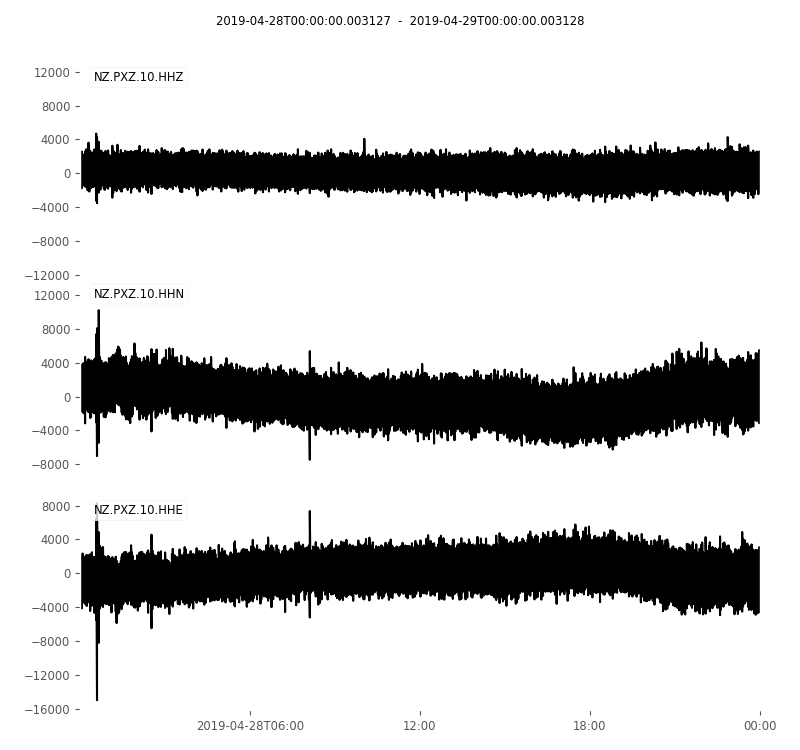

In [1]:
# Notebook set-up
%matplotlib widget
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import numpy as np
from obspy import UTCDateTime
from obspy.clients.fdsn import Client

client = Client("GEONET")
starttime = UTCDateTime(2019, 4, 28)
endtime = starttime + 86400

##############
# inv = client.get_stations(network="NZ", station="PXZ",
#                                 starttime=starttime,
#                                 endtime=endtime,level="response")

##############

st = client.get_waveforms(
    network="NZ", location="10", station="PXZ", channel="HH?",
    starttime=starttime, endtime=endtime)

##############
# st.remove_response(inv)
##############

fig = st.plot(handle=True)
plt.show()

The data we have downloaded are for a station near Porangahau - this region is prone to earthquake swarms, and the one we are going to look at here
appears to be associated with an ongoing slow-slip episode (check out the GNSS time-series plots for site [CKID](https://www.geonet.org.nz/data/gnss/map) near Cape Kidnappers).  GeoNet has a number of earthquakes on this day, lets have a look at what they have close
to this station and see if we can detect them all.

GeoNet has 9 events between 2019-04-28T00:00:00.000000Z and 2019-04-29T00:00:00.000000Z in the region of interest


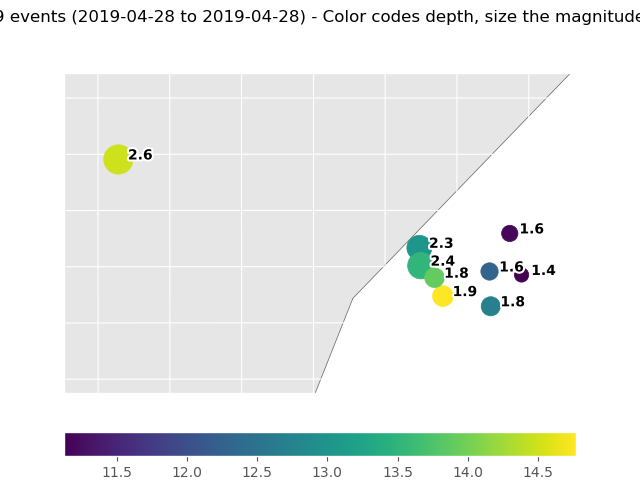

In [2]:
geonet_catalog = client.get_events(
    starttime=starttime, endtime=endtime,
    minlatitude=-40.406, maxlatitude=-40.137,
    minlongitude=176.588, maxlongitude=176.88)
print("GeoNet has {0} events between {1} and {2} in the region of interest".format(
    len(geonet_catalog), starttime, endtime))
fig = geonet_catalog.plot(projection="local", resolution="h")

Now that we have some data that we know is likely to contain earthquake waveforms, lets have a look at one of the earthquakes and see if
we can see the characteristics that differentiate it from noise. Lets pick the first earthquake in the catalog we downloaded for simplicity.

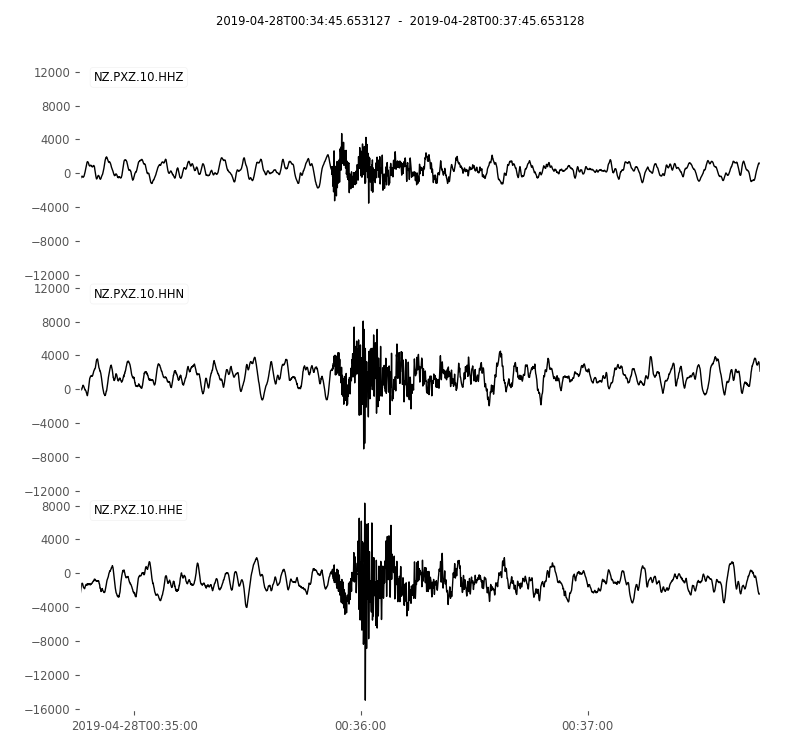

In [3]:
event = geonet_catalog[0]
# Trim the waveform around the event
event_st = st.slice(
    event.preferred_origin().time - 60,
    event.preferred_origin().time + 120).copy()
fig = event_st.plot(handle=True)
plt.show()

We can see there is a clear change in amplitude and frequency - we can also look at the spectrogram to see those changes.

In [4]:
event_st.select(component="Z")

1 Trace(s) in Stream:
NZ.PXZ.10.HHZ | 2019-04-28T00:34:45.653127Z - 2019-04-28T00:37:45.653127Z | 100.0 Hz, 18001 samples

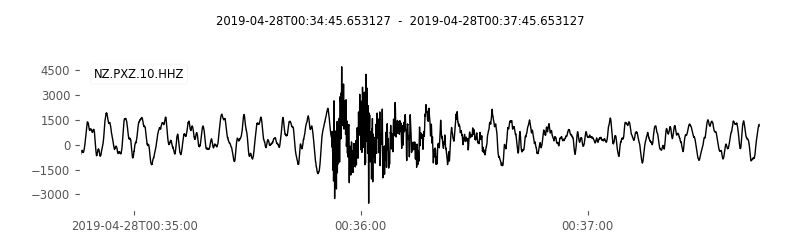

[<Axes: >]

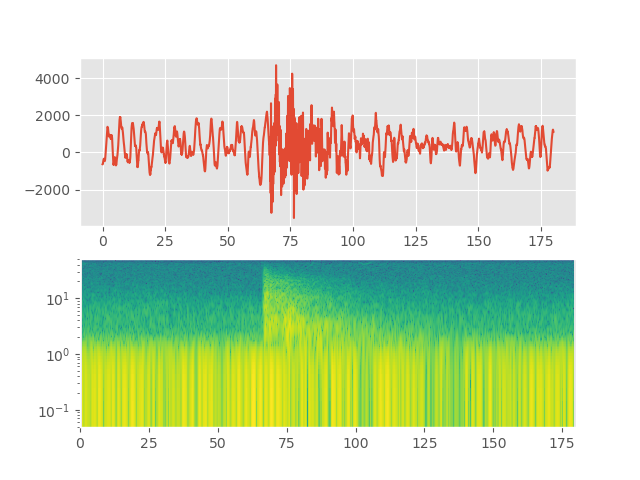

In [5]:
fig, axs = plt.subplots(2,1)
axs[0].plot(event_st.select(component="Z")[0].times(),event_st.select(channel="HHZ")[0].data)
event_st.select(component="Z")[0].plot(axes=axs[0])
event_st.select(component="Z").spectrogram(dbscale=True, log=True,axes=axs[1])

We can see that there is an increase in power above 2 Hz at the onset of the P-wave. We know that Earth's noise is dominant at low frequencies,
and we also know something about filtering.  Lets try highpassing the data to make the earthquake phases clearer. Remember that filtering
data changes the phase as well, so this will affect our estimation of when the earthquake phases arrive... Something to bear in mind when
thinking about phase-picking later! (*Note*: always try to pick on unfiltered data!)

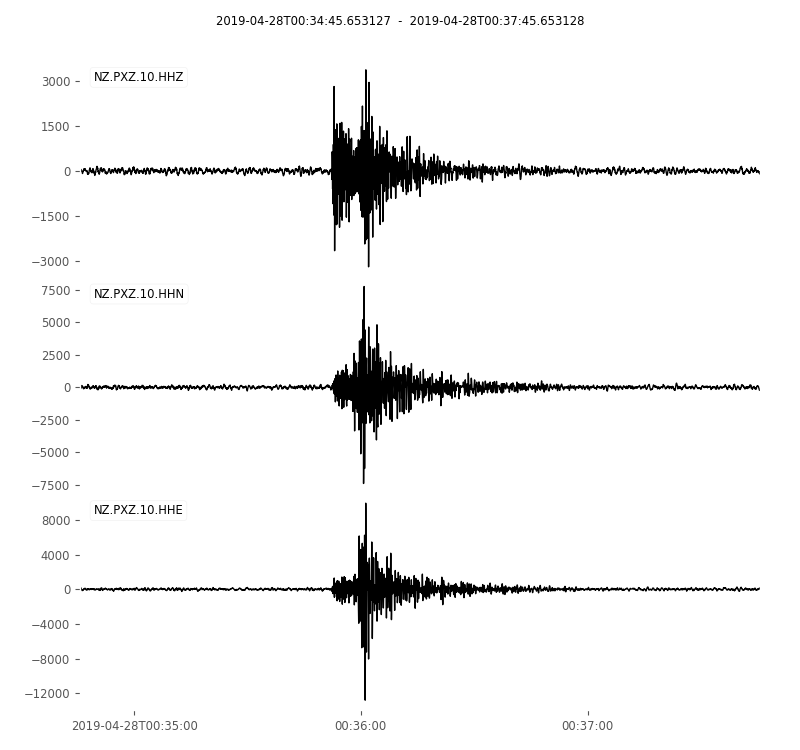

In [6]:
filtered = event_st.copy().detrend().filter("highpass", freq=1.5, corners=2)
fig = filtered.plot(equal_scale=False, handle=True)
plt.show()

Cool! That looks clearer - as ever, filters are useful for enhancing signal-to-noise ratio. What filters you apply are determined by what **you** think is noise and signal!

## Amplitude/energy detectors

One of the simplest ways to detect earthquakes is to look for high-amplitudes in our seismograms and assume that these are earthquake phase arrivals. We will develop one of these detectors and use it for our data.  Because we do not know the noise-level of our data, and noise level usually varies across stations and through time (night is usually quieter than day because of human activity, storms often increase noise levels, amongst other factors), we will use a ratio of the short-term amplitude (STA) to the long-term amplitude (LTA) to look for short duration increases in amplitude. This kind of detector is commonly termed an STA/LTA detector.

ObsPy has a few different [detectors](https://docs.obspy.org/tutorial/code_snippets/trigger_tutorial.html), including a [recursive sta/lta](https://docs.obspy.org/packages/autogen/obspy.signal.trigger.recursive_sta_lta.html#obspy.signal.trigger.recursive_sta_lta) detector that we are going to use here.

### 1. Non-recursive STA/LTA
```python
import numpy as np

def non_recursive_sta_lta(data, sta_window, lta_window):
    sta = np.zeros(len(data))
    lta = np.zeros(len(data))
    
    for i in range(len(data)):
        sta_start = max(0, i - sta_window)
        lta_start = max(0, i - lta_window)
        
        sta[i] = np.mean(np.square(data[sta_start:i+1]))
        lta[i] = np.mean(np.square(data[lta_start:i+1]))
    
    return sta / lta
```

### 2. Recursive STA/LTA
```python
import numpy as np

def recursive_sta_lta(data, sta_window, lta_window):
    a_sta = 1.0 / sta_window
    a_lta = 1.0 / lta_window
    
    sta = np.zeros(len(data))
    lta = np.zeros(len(data))
    
    sta[0] = np.square(data[0])
    lta[0] = np.square(data[0])
    
    for i in range(1, len(data)):
        sta[i] = a_sta * np.square(data[i]) + (1 - a_sta) * sta[i-1]
        lta[i] = a_lta * np.square(data[i]) + (1 - a_lta) * lta[i-1]
    
    return sta / lta
```

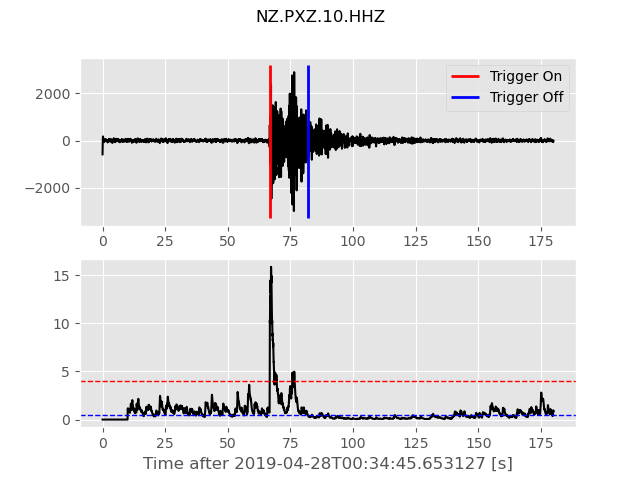

In [7]:
from obspy.signal.trigger import recursive_sta_lta, plot_trigger

tr = event_st.select(component="Z")[0]
tr = tr.copy().filter("highpass", freq=2, corners=2)
detector = recursive_sta_lta(
    tr.data, 
    nsta=int(0.5 * tr.stats.sampling_rate), 
    nlta=int(10 * tr.stats.sampling_rate))
fig = plot_trigger(tr, detector, thr_on=4, thr_off=0.5)

You can see that we get a peak in the STA/LTA ratio when the P-wave arrives. We would use that peak to generate an alert or trigger.  Usually some threshold is set to turn the trigger on (`thr_on` in the code above), and another threshold is set such that no triggers are raised until the STA/LTA ratio drops beneath that level (`thr_off` in the code above).  This second threshold is set to avoid multiple triggers for the different phases of the earthquake waveform. However, this can mean that closely spaced events are missed.

Play around with different STA and LTA lengths, a general rule of thumb is that your STA length should be similar 
to the duration of the impulsive P-arrival, and your LTA length should be long enough to capture a few wavelengths 
of the dominant low-frequency noise.

Try different filters as well, remember that filtering can be used to enhance signal and suppress noise, if
applied correctly!

In [7]:
# Try some different parameters here!

This is reasonably efficient, so we can easily apply this method to longer data streams.  Lets have a look at the
whole day of data and extract the detections and have a look at them! You can change the parameters to those that
you found to work well above.

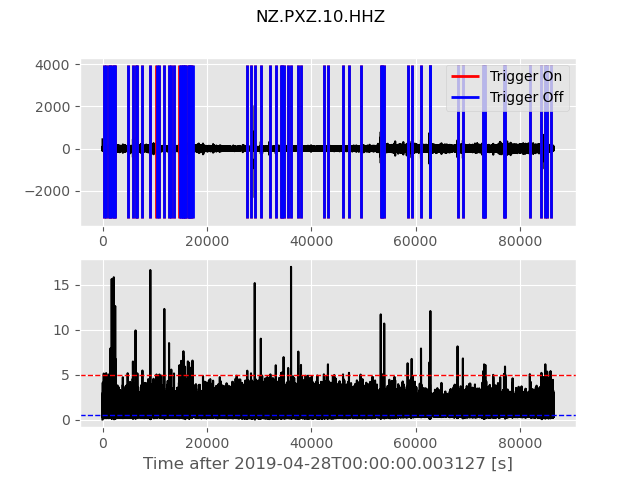

In [8]:
tr = st.select(component="Z")[0]
tr = tr.copy().filter("highpass", freq=2, corners=2)
detector = recursive_sta_lta(
    tr.data, 
    nsta=int(0.5 * tr.stats.sampling_rate), 
    nlta=int(10 * tr.stats.sampling_rate))
fig = plot_trigger(tr, detector, thr_on=5, thr_off=0.5)

Now that we have a charectaristic function (in this case our STA/LTA array), we can make
some detections.  To start with, we will set a threshold value and extract waveforms for
everything above that threshold:

Found 71 peaks


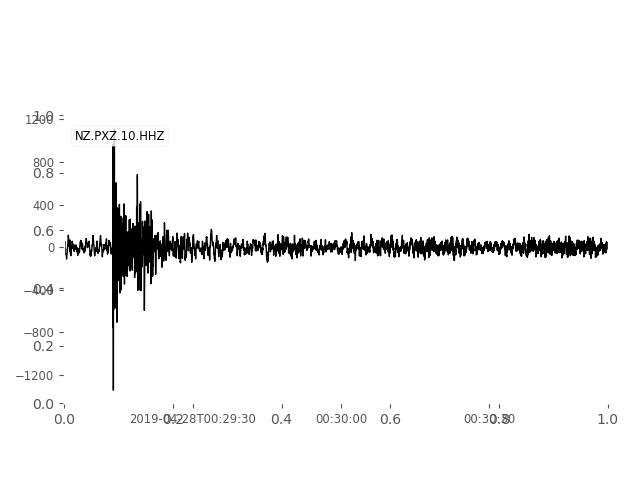

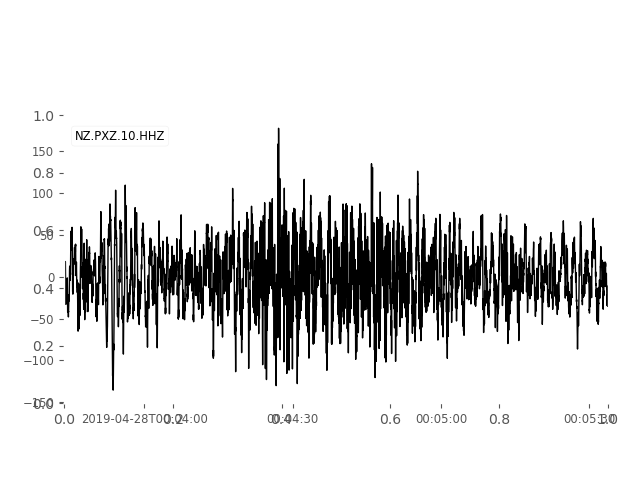

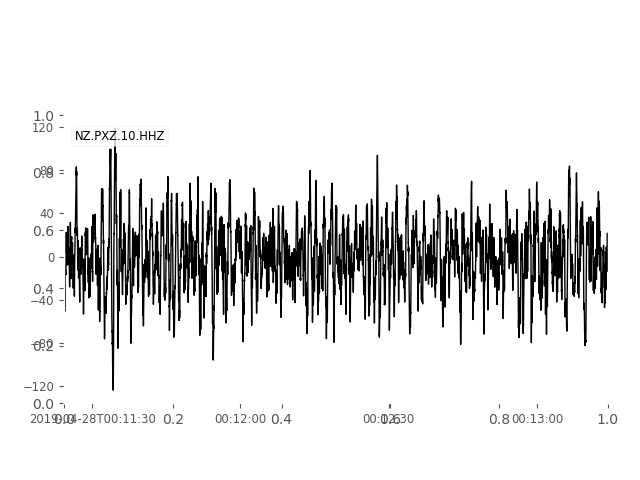

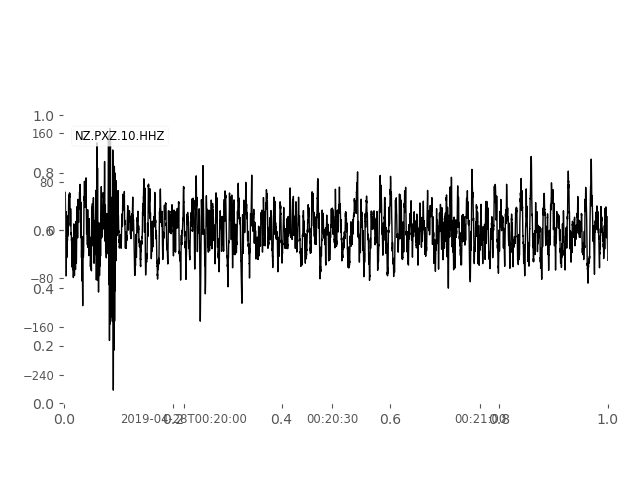

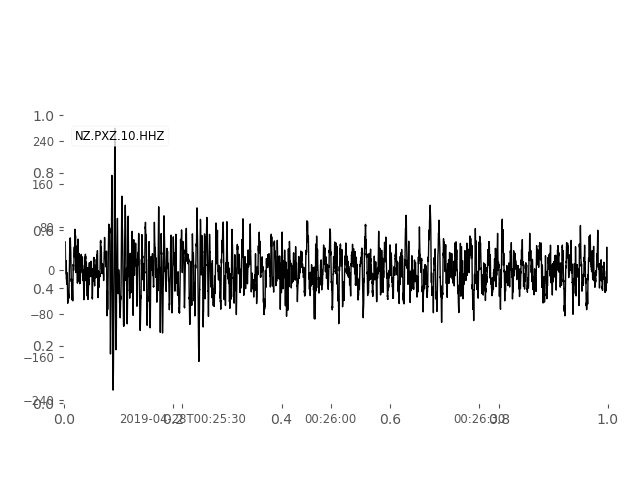

In [9]:
# Lets extract everything above some threshold
threshold = 5 #5.0
trigger_off_time = 2.0  # We won't allow re-triggering for this
# time in seconds after a trigger.

# We will use the scipy function: find_peaks to find the highest values - note that this
# is likely to not correspond to the P-onset.
from scipy.signal import find_peaks

peaks, _ = find_peaks(
    detector, height=threshold, 
    distance=int(trigger_off_time * tr.stats.sampling_rate))

peak_times = [tr.stats.starttime + (peak * tr.stats.delta) for peak in peaks]
print("Found {0} peaks".format(len(peaks)))

def extract_detections(tr, detection_times, pre_detection=10, post_detection=100):
    detections = []
    for detection in detection_times:
        detections.append(
            tr.slice(detection - pre_detection, 
                     detection + post_detection).copy())
    return detections

detections = extract_detections(tr, peak_times)

# Lets just look at the first five detections to avoid making lots of plots
for detection in detections[0:5]:
    fig, ax = plt.subplots()
    fig = detection.plot(fig=fig)
plt.show()

We can see that we can detect impulsive events (and quite a few non-implusive!), but so far we have only looked at a single station.  While this
can provide useful information, in general we need to see the waveforms on multiple stations to do anything useful
with the event (e.g. location). We also might have local noise sources like rockfalls, machinery, or lightning that
would raise a *false* trigger. To avoid these we can use a *coincidence triggering* routine. Obspy already has
a [coincidence triggering routine](https://docs.obspy.org/tutorial/code_snippets/trigger_tutorial.html), as well
as various different trigger routines.

We will make use of their recursive STA/LTA routine (which incorporates a decay term to reduce the effect of impulsive
events on the LTA after they have happened).We will also use the Obspy coincidence trigger function to find detections that are shared
across a network of stations.

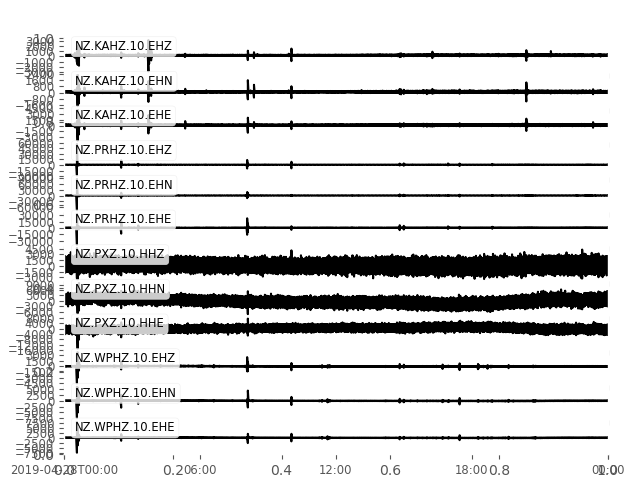

In [10]:
from obspy import Stream

sta_chans = [('PXZ', 'HH?'), ('PRHZ', 'EH?'), ('KAHZ', 'EH?'),
             ('WPHZ', 'EH?')]
st = Stream()
# Loop over the station, channel pairs defined above
for station, channel in sta_chans:
    st += client.get_waveforms(
        network="NZ", station=station, location="10",
        channel=channel, starttime=starttime, endtime=endtime) # 
fig, ax = plt.subplots()
fig = st.plot(equal_scale=False, size=(800, 750), fig=fig)

In [11]:
from obspy.signal.trigger import coincidence_trigger

st.filter("highpass", freq=2, corners=2)
st2 = st.select(component="Z") # It is normal to just use the
# vertical channel, but not necessary.

# Generate a list of triggers: note that this does not use an
# explicit re-triggering time limit, rather it uses a secondary
# threshold as discussed above.
# This will make detections only if a detection occurs on at-least
# 3 stations (set by thr_coincidence_sum)
trig = coincidence_trigger(
    "recstalta", thr_on=7.0, thr_off=1, 
    stream=st2, thr_coincidence_sum=3, sta=0.5, lta=10)
print("Found {0} triggers".format(len(trig)))

Found 14 triggers


Lets extract each detection on station PXZ, channel HHZ and look at them.

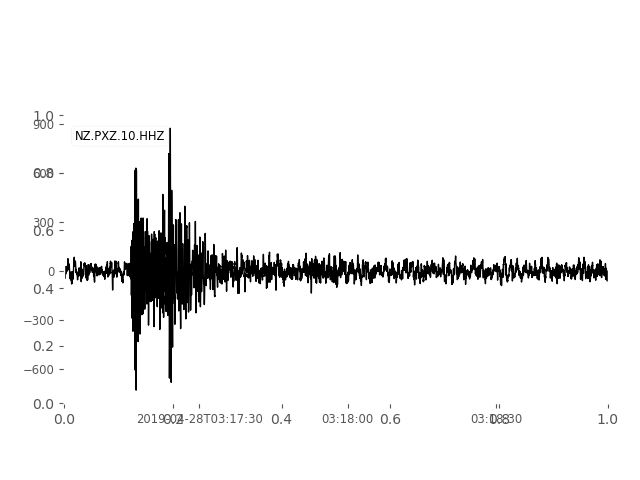

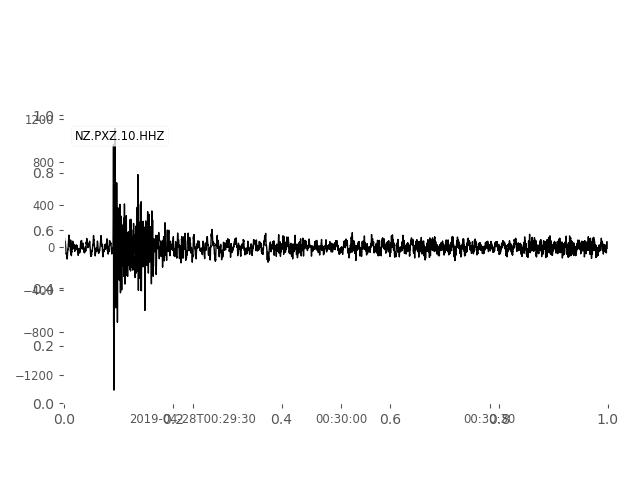

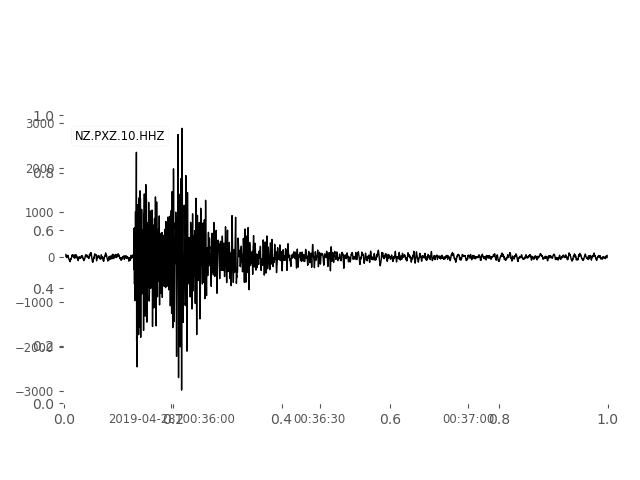

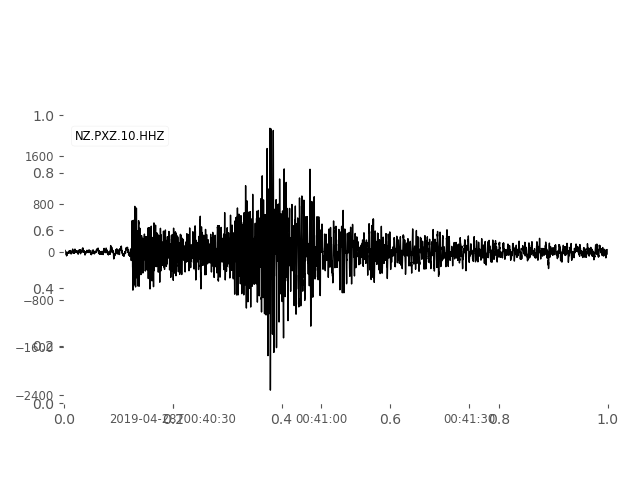

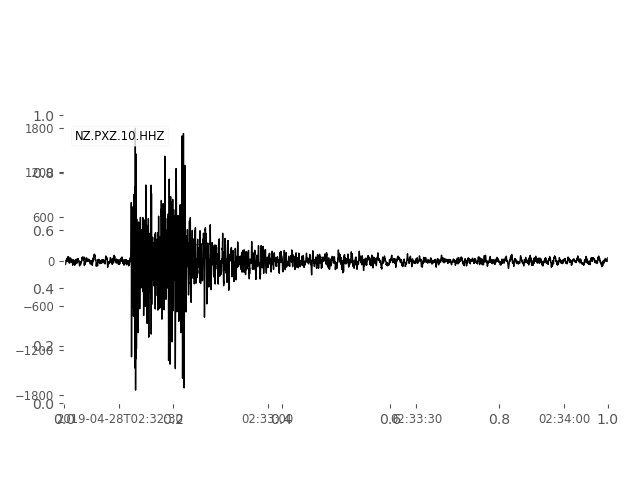

In [12]:
tr = st.select(station="PXZ", component="Z")[0]
detections = extract_detections(tr, [t['time'] for t in trig])
# Lets just look at the first five detections to avoid making lots of plots
for detection in detections[0:5]:
    fig, ax = plt.subplots()
    fig = detection.plot(fig=fig)
plt.show()

Clearly there are lots of impulsive events in this day, probably more than GeoNet has in it's catalogue.  You can play with the
parameters above and see what the thresholds do to the number of detections you make.  **BUT** GeoNet has strict parameters for detection that ensure only high-quality detections are retained - this means that there is space for scientists to do cool things!

It is common to take a list of detections from such a routine and then use an automatic picker, or to manually pick
the phases to determine which triggers are real and of interest, and which can be ignored.  For GeoNet, they use an
automatic picker, followed by manual evaluation of quality.  GeoNet often will not include events with fewer than
10 picks in its catalogue, which effectively limits the magnitude of completeness of the catalogue (the magnitude
above which all events are thought to be included in the catalogue). This often means that, with careful analysis,
many more earthquakes can be detected than are in the national catalogue.  Furthermore, by using data from additional stations, we can build an even more detailled picture of the seismicity in a region.

## Matched-filter detection

You will have noticed that lots of the earthquakes we detected above come from a similar location and have similar waveforms.
When earthquakes waveforms are similar we can exploit this similarity for detection: we can use correlation between a template
waveform and the continuous data to generate a characteristic function, and detect using that. This has a few advantages:
1. Correlation detectors are not as sensitive to noise amplitudes as energy (e.g. STA/LTA) detectors, so they
   can detect low signal-to-noise ratio events;
2. Correlation detectors do not require amplitudes to return to low levels, meaning that multiple events that
   occur close in time can be detected
   
However, similarity detectors have some major disadvantages:
1. You can only detect things that you have seen before - you need a template event;
2. This limits you to events close in space and with similar focal mechanisms.

This means that similarity detectors are really useful for swarms and aftershock sequences, but are less well suited
to detecting background seismicity.

Lets develop a simple, single-channel matched-filter for our swarm.  We will start by extracting the waveforms for
the events in the GeoNet catalog to use as *templates*, then we will correlate these with the continuous data.

/var/folders/0f/qh8vgw8n4g570f0r6q17pdz00000gn/T/ipykernel_58731/3839469970.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


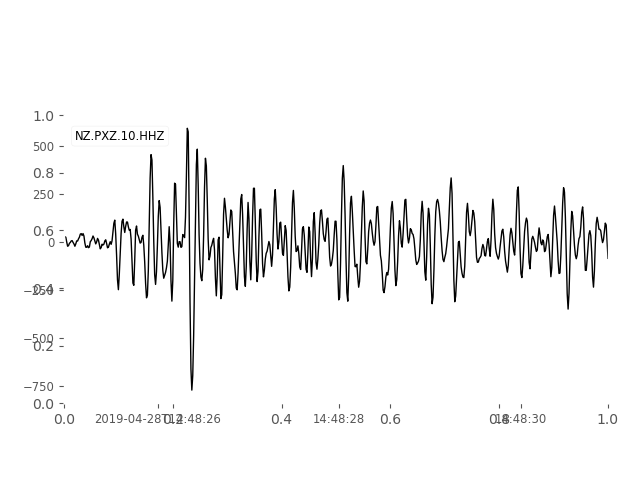

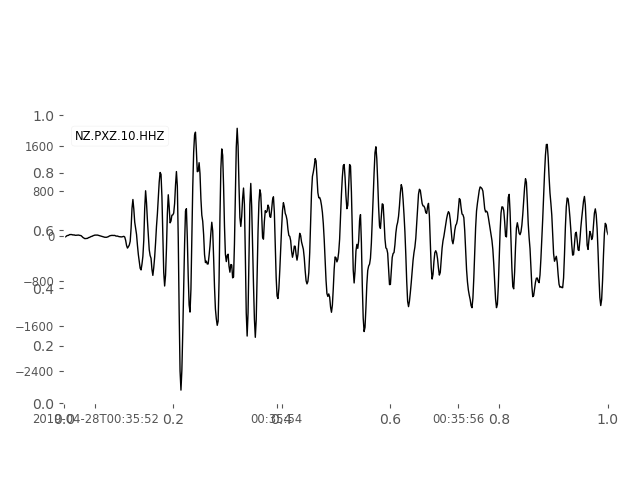

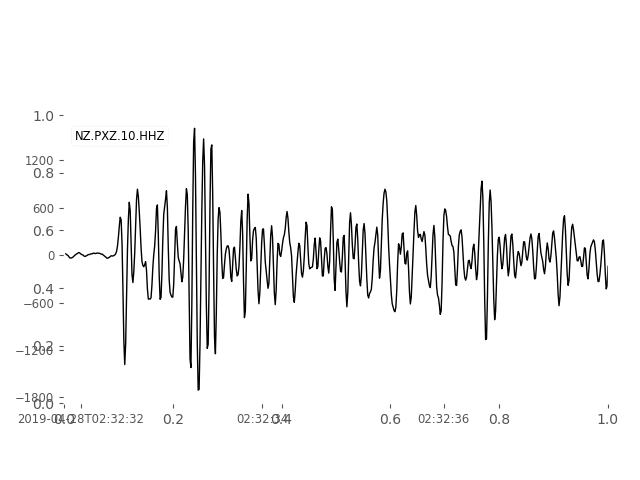

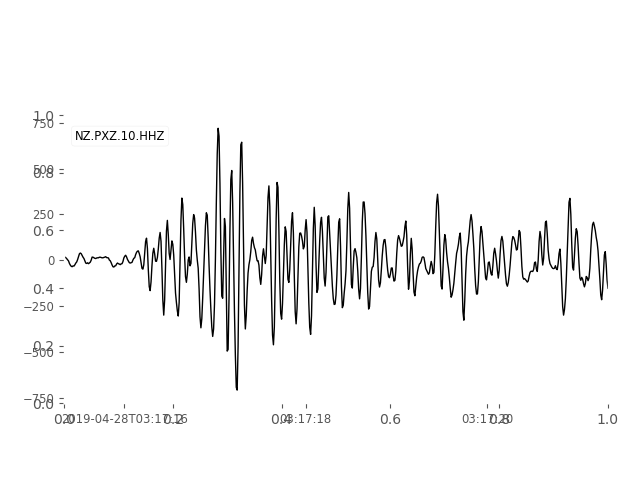

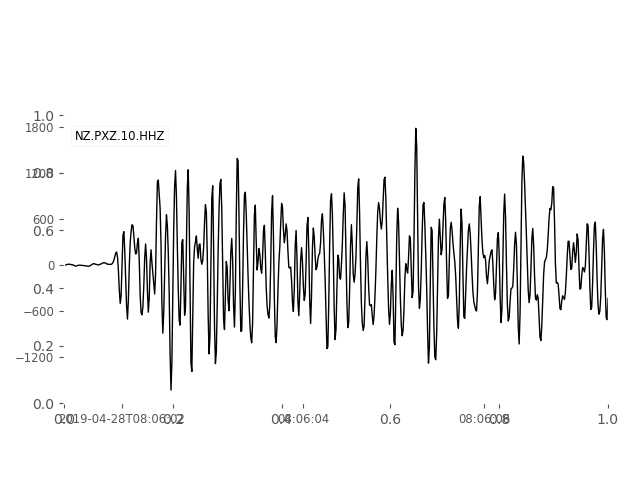

In [13]:
tr = st.select(station="PXZ", component="Z")[0]
filtered = tr.copy().detrend().filter("highpass", freq=2, corners=2)
geonet_times = [e.preferred_origin().time for e in geonet_catalog]
templates = extract_detections(
    tr=filtered, detection_times=geonet_times, pre_detection=-6, 
    post_detection=12)
# Lets just look at the first five again
for template in templates[0:5]:
    fig, ax = plt.subplots()
    fig = template.plot(fig=fig)
plt.show()

For the correlations we will use Obspy's [correlation detector](https://docs.obspy.org/packages/autogen/obspy.signal.cross_correlation.correlation_detector.html#obspy.signal.cross_correlation.correlation_detector) - there are also options in obspy for multi-channel
templates.  Other packages (including [EQcorrscan](https://eqcorrscan.readthedocs.io/en/latest/) and 
[FastMatchedFilter](https://github.com/beridel/fast_matched_filter)) have been developed to compute
matched-filter detections as well, and are often faster.

In [14]:
from obspy import Stream
from obspy.signal.cross_correlation import correlation_detector

threshold = 0.4  # Normalised correlations lie in the range -1.0 -- 1.0
trig_off_time = 2.0

# We have to give `correlation_detector` streams
stream = Stream([tr])
template_streams = [Stream([template]) for template in templates]

# The correlation detector is very memory intensive! So we loop through it to free memory each go.
detections = []
for template in template_streams:
    dets, _ = correlation_detector(
        stream=stream, templates=[template], heights=threshold, 
        distance=trig_off_time)
    detections.extend(dets)
print("Made {0} detections from {1} templates".format(
    len(detections), len(templates)))

Made 26 detections from 9 templates


Lets have a look at those detections!

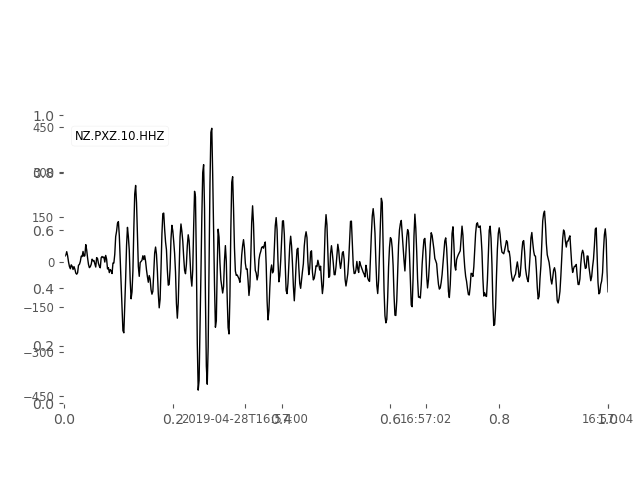

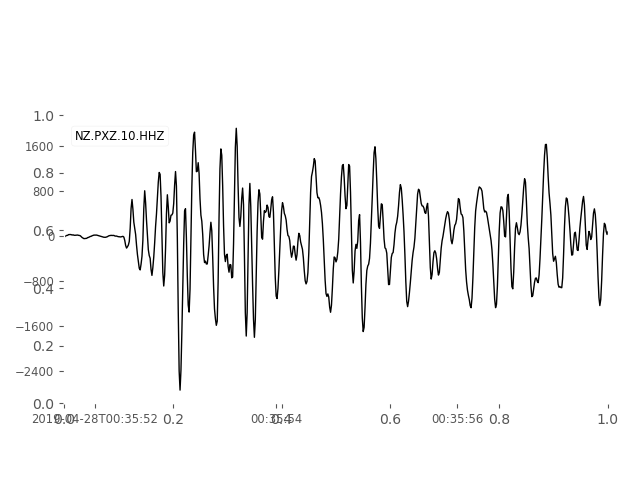

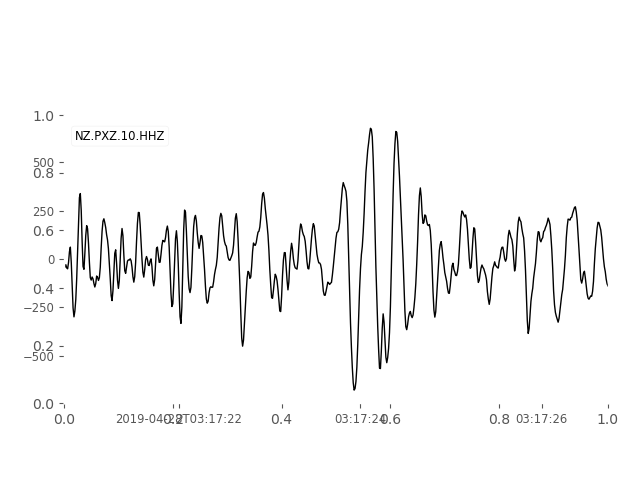

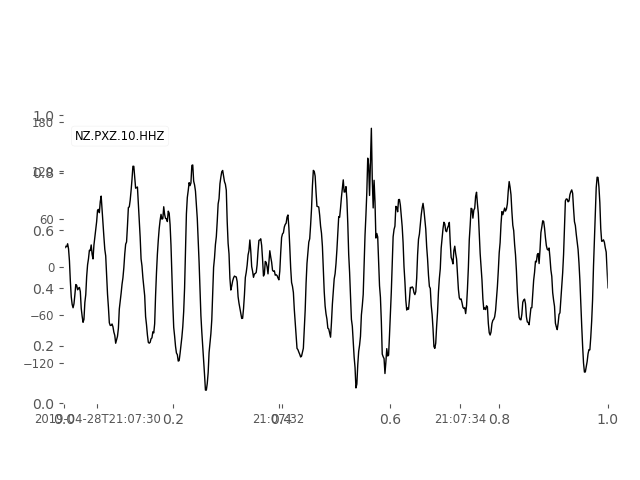

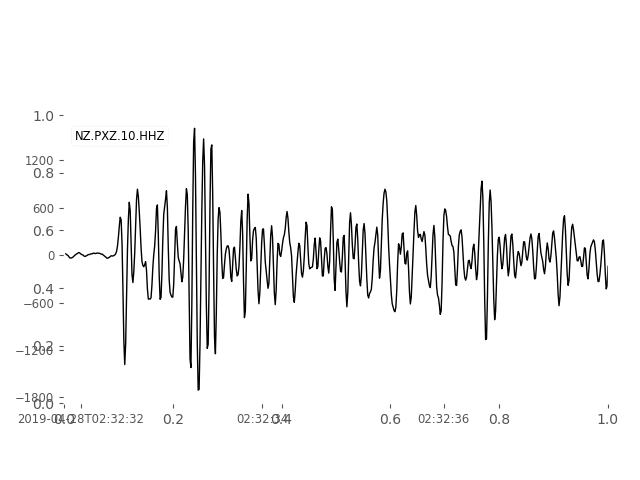

In [15]:
detection_waveforms = extract_detections(
    tr=filtered, pre_detection=0, post_detection=6,
    detection_times=[d["time"] for d in detections])
# Again, just the first five
for d in detection_waveforms[0:5]:
    fig, ax = plt.subplots()
    fig = d.plot(fig=fig)
plt.show()

Most of the detections look like earthquakes.  We could lower the threshold and make more detections, however we would be
better off extending to multiple stations.  For a demonstration of the efficacy of matched-filters to earthquake detection,
see the paper by [Warren-Smith et al. (2017)](https://pubs.geoscienceworld.org/ssa/srl/article/88/4/1065/354127/high-precision-analysis-of-an-aftershock-sequence).
This also documents a nice extension from detection to re-picking that then enables high-precision relocations to be computed
to study structures.  This is definitely recommended reading!

---

# Phase picking

Now we have detected some earthquakes we should do something with them.  We will discuss location of earthquakes in
a future class, but classical earthquake detection and analysis requires the
accurate identification of seismic phase arrivals.  In this section we will look at some picking strategies and
think about a few automatic pickers implemented in Obspy.

First, lets take an example of an earthquake in the GeoNet catalog and plot the waveforms with the picks overlain.

In [ ]:
from obspy import Stream
from obspy.clients.fdsn import Client

from gphs445_utilities.plot_event import get_geonet_waveforms, plot_picked

client = Client("GEONET")
cat = client.get_events(eventid="2018p546311")
event = cat[0]
print("Event has {0} picks".format(len(event.picks)))
# We will remove the picks from strong motion sites, they often have poor timing
# This "list-comprehension" overwrite the "picks" attibrute of the event
# with all the picks that were not made on a channel with code starting with "B"
event.picks = [p for p in event.picks 
               if p.waveform_id.channel_code[0] != "B"]

# Lets just look at the earliest picked ten stations.

# Sort the picks by time
event.picks.sort(key=lambda p: p.time)
# Make a list of the station codes for the first ten stations
first_ten_stations = {p.waveform_id.station_code for p in event.picks[0:10]}
# Now overwrite the "picks" attribute with only picks from one of those ten stations
event.picks = [p for p in event.picks if p.waveform_id.station_code in first_ten_stations]

# Now we will get the data that we want to plot
st = get_geonet_waveforms(
    event, delay=10, length=25, all_components=True)

# Write out the stream for later
st.write("Stream_to_be_picked.ms", format="MSEED")

fig = plot_picked(event, st)
plt.show()

Note that S-phases are more difficult for automatic pickers to identify correctly, and can be difficult to pick manually because the arrive within the coda of earlier waves (like the P-wavetrain!). However, the additional information from S arrivals can greatly improve locations, particularly for offshore earthquakes (with poor azimuthal coverage).

Lets zoom in on those P-picks.

In [ ]:
short_st = Stream()
for pick in event.picks:
    if pick.phase_hint[0].upper() != "P":
        continue
    tr = st.select(id=pick.waveform_id.get_seed_string())
    tr = tr.slice(pick.time - 0.5, pick.time + 2).copy()
    short_st += tr
short_st.merge().sort(["starttime"])
fig = plot_picked(event, short_st)
plt.show()

From this view we can see that some arrivals are more impulsive than others.  The general rule is to **pick the first break** where
a break is a deviation from the background noise to the earthquake waveform. This will give you the arrival of the first arriving P-phase, 
which can be used to infer the hypocenter; the location that the earthquake started.  Sometimes this first break can be hard to spot
the change, either due to emmergent waveforms (common in media that have strong resonance) or low signal to noise ratios. It is normal
to estimate your pick uncertainty when making manual picks.  This pick uncertainty can be incorporated into earthquake location inversions
to weight the inversion, and to constrain the final location uncertainty.  Remember that earthquake locations are models of where an earthquake
happened, and they have some intrinsic uncertainty associated with them.

## Pick your own

I have written a little interactive plot for you to pick your own waveforms with. You will use this for the assignment as well. Bear in mind that this is a simple application for picking P and S phases. Other software are available and would be recommended for research or commercial purposes because they give you more control and options for picking and uncertainty. Some popular software packages are:
- [Seisan](http://seis.geus.net/software/seisan/seisan.html)
- [SAC](https://ds.iris.edu/files/sac-manual/)
- [Seiscomp](https://www.seiscomp3.org/)

To start with we will try picking the event we just looked at. You can compare your picks to the GeoNet picks once you are done.

To use the picking GUI (Graphical User Interface), run the cell below.  A plotting window should pop-up along with some instructions beneath the cell below. You can use the mouse to pick and delete picks, and use the buttons (zoom window, arrows, forward, backwards) in the GUI window to move around the plot and get the where you want to be.  You can also resize the window to make it easier to see individual channels.

Once you are done you should close the window. The picks are automatically stored in memory and when you close the plot, they are returned as an event.  The final line of code in the cell below saves the picks to a file on disk.

**Note:** We need to use a fully interactive plotting backend for the `SeismicPicker` to work, using the line `%matplotlib` sets us up with the default backend.  You won't see plots in the notebook, instead you will get pop-up windows.

**YOU WILL NEED TO RESTART YOUR KERNEL (press the recycle button at the top of the screen) BEFORE RUNNING THE NEXT SET OF CELLS OTHERWISE THE PICKER WILL NEVER RETURN!**

In [ ]:
%matplotlib nbagg
from obspy import read
from gphs445_utilities.seismic_picker import SeismicPicker
from obspy.core.event import ResourceIdentifier

st = read("Stream_to_be_picked.ms")

event_id = "2018p546311"

picked_event = SeismicPicker(st).pick()

# Because this event already has an ID number, you can add that in to the event
# to help you keep track of things:
picked_event.resource_id = ResourceIdentifier(id=event_id)

# You will want to save your picks using this.
outfile = f"{event_id}_picked.xml"
picked_event.write(outfile, format="QUAKEML")
print(f"Written picks to {outfile}")
# Note you should try and keep the event ID in the filename

You can change the event_id above and you will get a different event to pick.  Pick at least 10 and compare
your picks to the GeoNet picks.

You can re-load your picks using:

```python
from obspy import read_events

catalog = read_events("your-pickfile-here") # Replace with the file you want to read in
```

## Machine learning

Recent advances in machine learning have led to novel earthquake detection methods. 
A [recent review paper](https://pubs.geoscienceworld.org/ssa/srl/article/90/1/3/566430/machine-learning-in-seismology-turning-data-into)
is worth a read to see how modern computational methods are being applied to earthquake detection and
characterization problems.